<a href="https://colab.research.google.com/github/Phatdat01/recommendation/blob/main/restaurantRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mlflow
!pip install gdown
!gdown 10xqEKqtA04JSKU2rF0XZQP9X34ovtgoY
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.5 MB 4.7 MB/s 
     |████████████████████████████████| 209 kB 67.0 MB/s 
     |████████████████████████████████| 182 kB 78.6 MB/s 
     |████████████████████████████████| 79 kB 10.5 MB/s 
     |████████████████████████████████| 575 kB 80.0 MB/s 
     |████████████████████████████████| 147 kB 82.9 MB/s 
     |████████████████████████████████| 82 kB 602 kB/s 
     |████████████████████████████████| 78 kB 9.6 MB/s 
     |████████████████████████████████| 140 kB 68.3 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 62 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.4-py3-none-any.whl size=142894 sha256=be25a877cae30c19197cea06431ae312c669bf58a79d2c4a03415dd7775bfc15
  Stored in directory: /root/.cache/pip/wheels/4

In [ ]:
%cd /content
!pip install --upgrade --no-cache-dir gdown
!python -m gdown.cli "https://drive.google.com/uc?id=10xqEKqtA04JSKU2rF0XZQP9X34ovtgoY&confirm=t"

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=10xqEKqtA04JSKU2rF0XZQP9X34ovtgoY&confirm=t
To: /content/yelp_dataset.tar
100% 4.34G/4.34G [00:35<00:00, 121MB/s]


In [ ]:
# or
#gdown PTkzqSj9IV1H64h7A6L9sQDvCTbVhEz

In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.recommendation import ALSModel
from pyspark.sql import Row
import numpy as np
from datetime import datetime
import tarfile
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import Window
from pyspark.sql.window import *

In [ ]:
%cd /content
# !mkdir yelp_dataset
my_tar = tarfile.open('/content/yelp_dataset.tar')
my_tar.extract('yelp_academic_dataset_review.json',".")
my_tar.close()
!rm /content/yelp_dataset.tar

/content


In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '5000')\
        .getOrCreate()

In [ ]:
df = spark.read.json("/content/yelp_academic_dataset_review.json")
df.printSchema()
df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

In [ ]:
ratings=df.select("user_id","business_id","stars","date","cool","funny","useful")

In [ ]:
userRatings=ratings.groupBy("user_id").count()
## take id type int
window = Window.orderBy(col('user_id'))
userRatings = userRatings.withColumn('userid', row_number().over(window))

##Because ALS in spark require users or items is  in int type, we must process it

## if you use this, for the large data, it processes wrong
# userRatings=ratings.groupBy("user_id").count().withColumn("userid", monotonically_increasing_id().cast(IntegerType()))
userRatings.show(5)

+--------------------+-----+------+
|             user_id|count|userid|
+--------------------+-----+------+
|---1lKK3aKOuomHnw...|    1|     1|
|---2PmXbF47D870st...|   28|     2|
|---UgP94gokyCDuB5...|   11|     3|
|---fa6ZK37T9NjkGK...|    1|     4|
|---r61b7EpVPkb4UV...|    5|     5|
+--------------------+-----+------+
only showing top 5 rows



In [ ]:
buiRatings=ratings.groupBy("business_id").count()
## take id type int
window = Window.orderBy(col('business_id'))
buiRatings = buiRatings.withColumn('businessid', row_number().over(window))

# buiRatings=ratings.groupBy("business_id").count().withColumn("businessid", monotonically_increasing_id().cast(IntegerType()))
newratings=ratings.join(userRatings, ['user_id'])
newratings=newratings.join(buiRatings, ['business_id'])
newratings=newratings.select("userid","businessid","stars","date","cool","funny","useful")

In [ ]:
print(f"num user: {userRatings.count()}")
print(f"num buisiness: {buiRatings.count()}")
newratings.show(5)
print(f"dataframe: {newratings}")

num user: 1987929
num buisiness: 150346
+------+----------+-----+-------------------+----+-----+------+
|userid|businessid|stars|               date|cool|funny|useful|
+------+----------+-----+-------------------+----+-----+------+
|    20|     40541|  1.0|2015-05-03 03:53:01|   1|    0|     3|
|    20|     76452|  5.0|2015-05-21 03:18:49|   0|    0|     0|
|    36|    105552|  5.0|2019-04-18 05:17:58|   0|    0|     0|
|    36|     29020|  2.0|2017-02-03 06:14:50|   0|    0|     1|
|    36|    107435|  5.0|2019-04-18 05:15:48|   1|    1|     1|
+------+----------+-----+-------------------+----+-----+------+
only showing top 5 rows

dataframe: DataFrame[userid: int, businessid: int, stars: double, date: string, cool: bigint, funny: bigint, useful: bigint]


In [ ]:
newratings=newratings.withColumn("stars",col("stars").cast(IntegerType()))
newratings=newratings.withColumn("date",to_timestamp("date"))
newratings=newratings.withColumn("cool",col("cool").cast(IntegerType()))
newratings=newratings.withColumn("funny",col("funny").cast(IntegerType()))
newratings=newratings.withColumn("useful",col("useful").cast(IntegerType()))

print(newratings)
newratings.show(5)

DataFrame[userid: int, businessid: int, stars: int, date: timestamp, cool: int, funny: int, useful: int]
+------+----------+-----+-------------------+----+-----+------+
|userid|businessid|stars|               date|cool|funny|useful|
+------+----------+-----+-------------------+----+-----+------+
|    20|     40541|    1|2015-05-03 03:53:01|   1|    0|     3|
|    20|     76452|    5|2015-05-21 03:18:49|   0|    0|     0|
|    36|    105552|    5|2019-04-18 05:17:58|   0|    0|     0|
|    36|     29020|    2|2017-02-03 06:14:50|   0|    0|     1|
|    36|    107435|    5|2019-04-18 05:15:48|   1|    1|     1|
+------+----------+-----+-------------------+----+-----+------+
only showing top 5 rows



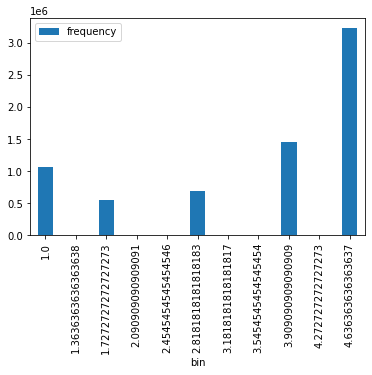

In [ ]:
gre_histogram = newratings.select('stars').rdd.flatMap(lambda x: x).histogram(11)

pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [ ]:
df1 = newratings.withColumn('year',year(newratings.date))
df1 = newratings.withColumn('year',year(newratings.date))
display(df1)

DataFrame[userid: int, businessid: int, stars: int, date: timestamp, cool: int, funny: int, useful: int, year: int]

## Split data

In [ ]:
num=int(newratings.count()*0.1)
ortherDate=newratings.orderBy(col("date").desc())
testing=ortherDate.limit(int(num))
train=ortherDate.subtract(testing)

validate=train.limit(int(num)*2)
training=train.subtract(validate)

print(f"training: {training.count()}")
print(f"validate: {validate.count()}")
print(f"testing: {testing.count()}")

training: 4893182
validate: 1398056
testing: 699028


## Because there is some problem if you collect by date  while the items don't have any rating, so it can be difficult to predict

In [ ]:
def divideData(data,ratio,numRow):
    num=int(numRow*2*ratio)
    ortherDate=data.orderBy(col("date").desc())
    testing=ortherDate.limit(int(num))
    (_, testing) = testing.randomSplit([0.5, 0.5])
    training = data.subtract(testing)
    return training,testing

def splitData(newratings,ratioVal,ratioTest):
    numRow=newratings.count()
    train,testing = divideData(newratings,ratioTest,numRow)
    training,validating = divideData(train,ratioVal,numRow)
    return training,validating,testing

In [ ]:
training,validating,testing=splitData(newratings,0.2,0.1)
print(f"num training: {training.count()}")
print(f"num validating: {validating.count()}")
print(f"num testing: {testing.count()}")
testing.show(5)

num training: 4891272
num validating: 1399214
num testing: 699779
+------+----------+-----+-------------------+----+-----+------+
|userid|businessid|stars|               date|cool|funny|useful|
+------+----------+-----+-------------------+----+-----+------+
|     3|     52915|    1|2020-05-12 01:45:33|   1|    0|     0|
|     3|     69507|    4|2021-09-17 17:36:13|   1|    0|     1|
|     3|    106341|    5|2020-10-07 16:14:15|   0|    0|     2|
|    10|     91657|    5|2021-04-19 14:33:52|   0|    0|     0|
|    24|     99643|    5|2020-05-24 19:33:09|   0|    0|     0|
+------+----------+-----+-------------------+----+-----+------+
only showing top 5 rows



# Choose param

In [ ]:
rank=25
reg=0.09
iter=5
als= ALS(rank=rank, maxIter=iter, regParam=reg, userCol="businessid", itemCol="userid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
model = als.fit(training) 
predictions=model.transform(validating)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)  
print(f"rank: {rank},iter: {iter},reg: {reg} : RMSE={rmse}")
f = open('/content/drive/MyDrive/TLCN-19133035-19133018/score.txt','a')
f.write(f'\n{rank},{iter},{reg},{rmse}')
f.close()

rank: 25,iter: 5,reg: 0.09 : RMSE=1.6038069896506904


In [ ]:
from pyspark.sql.types import StructType,StructField, StringType
import numpy as np

def tuning(rank,iter,reg):
  als= ALS(rank=rank, maxIter=iter, regParam=reg, userCol="businessid", itemCol="userid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
  model = als.fit(training) 
  predictions=model.transform(validating)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)  
  print(f"rank: {rank},iter: {iter},reg: {reg} : RMSE={rmse}")
  return rmse

ran=[0.2,0.7,0.9]

for reg in ran:
    for rank in range(11, 17, 2):
        for iter in range(11, 17, 2):
              rmse=tuning(rank,iter,reg)
              f = open('/content/drive/MyDrive/TLCN-19133035-19133018/score.txt','a')
              f.write(f'\n{rank},{iter},{reg},{rmse}')
              f.close()

rank: 5,iter: 3,reg: 0.9 : RMSE=1.6271337657801292
rank: 5,iter: 5,reg: 0.9 : RMSE=1.6125856824966942
rank: 5,iter: 7,reg: 0.9 : RMSE=1.6087505923848164
rank: 5,iter: 9,reg: 0.9 : RMSE=1.6072348040049016
rank: 5,iter: 11,reg: 0.9 : RMSE=1.606568679510409
rank: 5,iter: 13,reg: 0.9 : RMSE=1.606247424865696


In [ ]:
alsExplicit = ALS()

paramMapExplicit = ParamGridBuilder() \
                    .addGrid(alsExplicit.rank, [8, 12]) \
                    .addGrid(alsExplicit.maxIter, [10, 15]) \
                    .addGrid(alsExplicit.regParam, [1.0, 10.0]) \
                    .build()
evaluatorR = RegressionEvaluator(metricName="rmse", labelCol="rating")

cvExplicit = CrossValidator(estimator=alsExplicit, estimatorParamMaps=paramMapExplicit, evaluator=evaluatorR)
cvModelExplicit = cvExplicit.fit(dfRatings)
predsExplicit = cvModelExplicit.bestModel.transform(dfRatingsTest)


# Normal

In [ ]:
# from multiprocessing.pool import ThreadPool as Pool
# from datetime import datetime

# def worker(i):
#   start=datetime.now()
#   print(f"processing time: {datetime.now()}")
#   als= ALS(rank=5, maxIter=5, regParam=0.15, userCol="userid", itemCol="businessid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
#   model = als.fit(training)
#   print(f"processing time: {datetime.now()}")
#   predictions=model.transform(validate)
#   print(f"processing time: {datetime.now()}")
#   evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
#   rmse = evaluator.evaluate(predictions)
#   print(f"time {i} RMSE={rmse}")
#   end=datetime.now()
#   print(f"processing time: {end-start}")
    
# # pool = Pool(2)
# item=5
# worker(item)

In [ ]:
als= ALS(rank=4, maxIter=4, regParam=0.35, userCol="userid", itemCol="businessid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
model = als.fit(training)
predictions=model.transform(training)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"training RMSE={rmse}")

predictions=model.transform(validate)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"validate RMSE={rmse}")

training RMSE=0.9405448523205645
validate RMSE=1.1839087988996344


In [ ]:
predictions=model.transform(testing)
rmse = evaluator.evaluate(predictions)
print(f"validate RMSE={rmse}")

validate RMSE=1.5190787034550957


# Save model

In [ ]:
model.save('/content/save1')

In [ ]:
%cd /content
import shutil
shutil.make_archive('save1', 'zip', 'save1')

/content


'/content/save1.zip'

In [ ]:
shutil.copy('/content/save1.zip','/content/drive/MyDrive/TLCN-19133035-19133018/MLS')

'/content/drive/MyDrive/TLCN-19133035-19133018/MLS/save1.zip'

# Load save model

In [ ]:
!gdown 18e1h76domGD_WVnl4vF6OaUyUXVGxqeC
shutil.unpack_archive('/content/save1.zip',"save1")

Downloading...
From: https://drive.google.com/uc?id=18e1h76domGD_WVnl4vF6OaUyUXVGxqeC
To: /content/save1.zip
100% 26.0M/26.0M [00:00<00:00, 152MB/s]


In [ ]:
model=ALSModel.load("/content/save1")

evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")

predictions=model.transform(training)
rmse = evaluator.evaluate(predictions)
print(f"training: rmse={rmse}")

predictions=model.transform(validate)
rmse = evaluator.evaluate(predictions)
print(f"validate: rmse={rmse}")

predictions=model.transform(testing)
rmse = evaluator.evaluate(predictions)
print(f"testing: rmse={rmse}")

training: rmse=0.940544852320557
validate: rmse=1.1839087988996344
testing: rmse=1.5190787034550957


# stratified sampling

In [ ]:
rat1=newratings.where(col("stars")==1)
rat2=newratings.where(col("stars")==2)
rat3=newratings.where(col("stars")==3)
rat4=newratings.where(col("stars")==4)
rat5=newratings.where(col("stars")==5)

In [ ]:
def trainTestSPlit(newratings):
    numtest=int(newratings.count()*0.4)
    ortherDate=newratings.orderBy(col("date").desc())
    testing=ortherDate.limit(int(numtest))
    (_, testing) = testing.randomSplit([0.5, 0.5])
    training = newratings.subtract(testing)
    return training,testing

In [ ]:
train1,test1=trainTestSPlit(rat1)
train2,test2=trainTestSPlit(rat2)
train3,test3=trainTestSPlit(rat3)
train4,test4=trainTestSPlit(rat4)
train5,test5=trainTestSPlit(rat5)

In [ ]:
mertrain=train1.union(train2).union(train3).union(train4).union(train5)
mertest=test1.union(test2).union(test3).union(test4).union(test5)

In [ ]:
from multiprocessing.pool import ThreadPool as Pool
from datetime import datetime

predictions=None

def work(i,train,test):
  start=datetime.now()
  als= ALS(rank=i, maxIter=5, regParam=0.15, userCol="businessid", itemCol="userid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
  model = als.fit(train)
  ski=datetime.now()-start
  print(f"Time fit model: {ski}")
  predictions=model.transform(test)
  print(f"Time predict: {datetime.now()-ski}")
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  print(f"time {i} RMSE={rmse}")
  end=datetime.now()
  print(f"processing time: {end-start}")
  return predictions

i=0   
for item in range(3,15):
  prediction=work(item,mertrain,mertest)
  if i==1:
    predictions=prediction
  i+=1


# Cross validation

In [ ]:
# Cross validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

als= ALS(rank=5, maxIter=5, regParam=0.15, userCol="userid", itemCol="businessid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
print("Load complete als model")
print(als)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
params = ParamGridBuilder().addGrid(als.regParam,[.01, .05, .1, .15]).build()
print(params)
print("That's params")
cv = CrossValidator(estimator=als, estimatorParamMaps=params, evaluator=evaluator, parallelism=4, numFolds= 5)
print(f"Load cross validation {cv}")
best_model = cv.fit(newratings)
model = best_model.bestModel
print(model)

Load complete als model
ALS_6581ec885334
[{Param(parent='ALS_6581ec885334', name='regParam', doc='regularization parameter (>= 0).'): 0.01}, {Param(parent='ALS_6581ec885334', name='regParam', doc='regularization parameter (>= 0).'): 0.05}, {Param(parent='ALS_6581ec885334', name='regParam', doc='regularization parameter (>= 0).'): 0.1}, {Param(parent='ALS_6581ec885334', name='regParam', doc='regularization parameter (>= 0).'): 0.15}]
That's params
Load cross validation CrossValidator_37a77c99dc94


In [ ]:
predictions=model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"RMSE={rmse}")

# Recommendation Show

In [ ]:
rcm = model.recommendForAllUsers(10)
rcm.show(10)

In [ ]:
recommendations = rcm.withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("newratings.businessid"), col("newratings.stars"))
recommendations.limit(10).show()